# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Pairs Trading Strategy

Pairs trading is a market neutral strategy where we go long on one crypto pair and short other crypto pair, betting that the spread between the two would eventually converge to their mean.

In this notebook, we will create a pairs trading strategy. The strategy works as follows:
1. Fetch the daily price data of the Bitcoin and Monero. <br><br>
2. Calculate the hedge ratio using the ordinary least square method. <br> <br>
3. Calculate the spread using the hedge ratio. <br> <br>
4. Check for cointegration using the ADF test. <br> <br>
5. Calculate the Bollinger bands <br> <br>
6. Trading signals <br> <br>
6.1. If the spread moves below the lower Bollinger band then buy the spread. <br>
6.2. If the spread moves above the upper Bollinger band then sell the spread. <br> <br>
7. Compute the strategy returns

### Import the data

Fetch the Bitcoin and Monero data from csv files using the pandas 'read_csv' function. The source of the data is Cryptocompare.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')

# Get historical data for BTC/USD and XMR/USD
BTC = pd.read_csv('../data_modules/Poloniex_BTCUSD.csv', index_col=0)
XMR = pd.read_csv('../data_modules/Poloniex_XMRUSD.csv', index_col=0)

# Create a dataframe df and store the closing price of BTC/USD and XRM/USD in a column name BTC and XRM respectively.
df = pd.DataFrame({'BTC': BTC.Close, 'XMR': XMR.Close})
df.tail(10)

,BTC,XMR
Date,,
07-10-2018,6607.94,114.05
08-10-2018,6674.06,114.48
09-10-2018,6654.92,113.46
10-10-2018,6630.20,114.73
11-10-2018,6250.28,100.60
12-10-2018,6304.11,102.35
13-10-2018,6329.23,104.00
14-10-2018,6342.37,101.43
15-10-2018,6742.00,109.74


### Calculate the hedge ratio
Hedge ratio is calculated using the linear regression.<br>
The linear equation typically takes the form:<br>
y = βX + ϵ <br>
where
y is the dependent variable, X is the independent variables, and β is the slope that we want to estimate and
ϵ is the error term.<br> 

The OLS function from the statsmodels package is used to calculate the hedge ratio. The function takes dependent_variable(y) and independent_variable(X) as parameters. <br> <br>
sm.OLS (dependent_variable(y), independent_variable(X))

In [2]:
# Import statsmodels package
import statsmodels.api as sm

# Create and fit the linear model
reg = sm.OLS(df.BTC.iloc[:90], df.XMR.iloc[:90]).fit()

# Extract the parameter
hedge_ratio = reg.params[0]
print("Hedge Ratio = ", hedge_ratio)

Hedge Ratio =  51.596751123326115


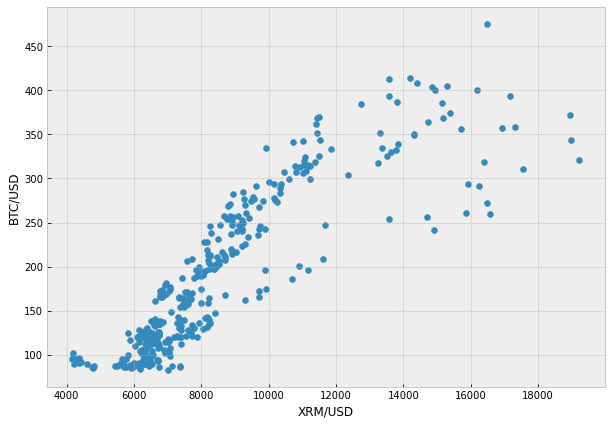

In [3]:
# Plot the scatter graph
plt.figure(figsize=(10, 7))
plt.scatter(df['BTC'], df['XMR'])
plt.xlabel("XRM/USD")
plt.ylabel("BTC/USD")
plt.show()

### Calculate the Spread

We calculate the spread using the hedge ratio.<br>

<b>Spread </b> = independent_variable - hedge_ratio * dependent_variable

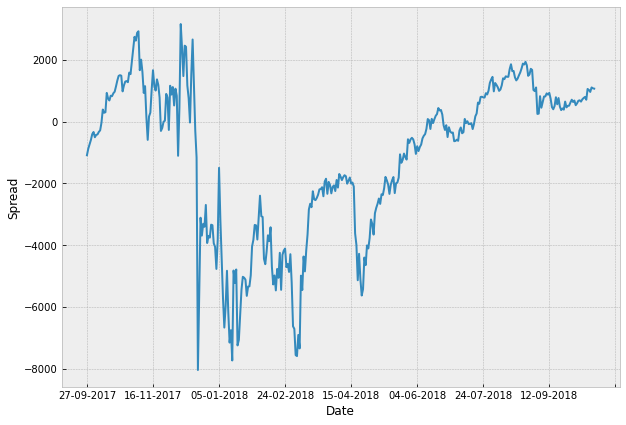

In [4]:
# Calculate the spread
df['spread'] = df.BTC - hedge_ratio * df.XMR

# Plot the Spread
df.spread.plot(figsize=(10, 7))
plt.ylabel('Spread')
plt.show()

### Cointegration Check

We check whether the crypto pair is cointegrated or not. We use the ADF test to check the cointegration.

In [5]:
import statsmodels.tsa.stattools as ts

# Check cointegration using the adfuller function
coint = ts.adfuller(df.spread.iloc[:90])

print ('test statistic =',coint[0])  
print ('critical value =',coint[4]) 

test statistic = -2.68812316900156
critical value = {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}


The test statistics is less than critical values at 90% confidence levels. So, we can reject the null hypothesis and state that the BTC/USD and XMR/USD are cointegrated with 90% confidence level from Sep 27, 2017 to  Oct 16, 2018. 

### Bollinger band calculation<br>
Upper Band: The upper band is the 'n' standard deviations above the moving average of the price. <br>
Middle Band: The middle band is the moving average of the price.<br>
Lower Band: The lower band is the 'n' standard deviations below the moving average of the price. <br>


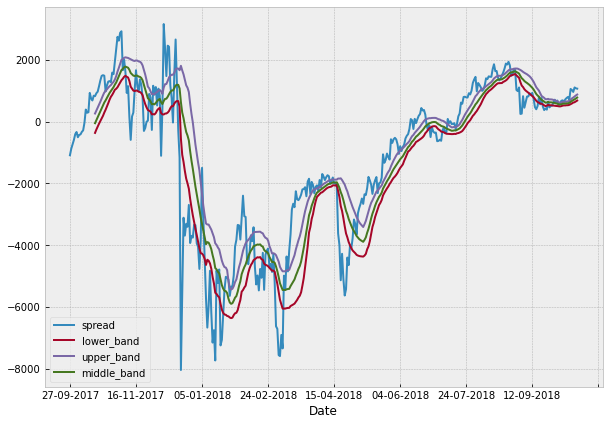

In [6]:
# Calculte Moving Average
df['moving_average'] = df.spread.rolling(20).mean()

# Calculate Moving Standard deviation
df['moving_std_dev'] = df.spread.rolling(20).std()

# Calcuate Upper band, middle band and lower band
df['upper_band'] = df.moving_average + 0.5 * df.moving_std_dev
df['middle_band'] = df.moving_average
df['lower_band'] = df.moving_average - 0.5 * df.moving_std_dev

# Plot the Bollinger bands with spread
df[['spread', 'lower_band', 'upper_band', 'middle_band']].plot(figsize=(10, 7))
plt.show()

###  Trading signals
<b>Buy Signal</b>:<br>
If spread crosses below the lower Bollinger band then buy the spread and exit the position when it reaches to the middle band. <br>
<b>Sell Signal</b>:<br>
If spread crosses above the upper Bollinger band then sell the spread and exit the position when it reaches to the middle band.

In [7]:
# Import numpy
import numpy as np

# Long Entry
df['long_position'] = np.where(df.spread < df.lower_band, 1, 0)

# Long Exit
df['long_position'] = np.where(
    df.spread >= df.middle_band, 0, df.long_position)

# Short Entry
df['short_position'] = np.where(df.spread > df.upper_band, -1, 0)

# Short exit
df['short_position'] = np.where(
    df.spread <= df.middle_band, 0, df.short_position)

# Fill NaN values
df = df.fillna(method='ffill')

# Combine the positions
df['position'] = df.long_position + df.short_position

### Calculate the strategy returns

1) Calcuate the daily returns of BTC <br>
2) Calculate the daily returns of XMR<br>
3) Calculate daily returns by subtracting daily returns of XMR from BTC <br>
4) The strategy returns are generated by multiplying the previous position with the daily returns



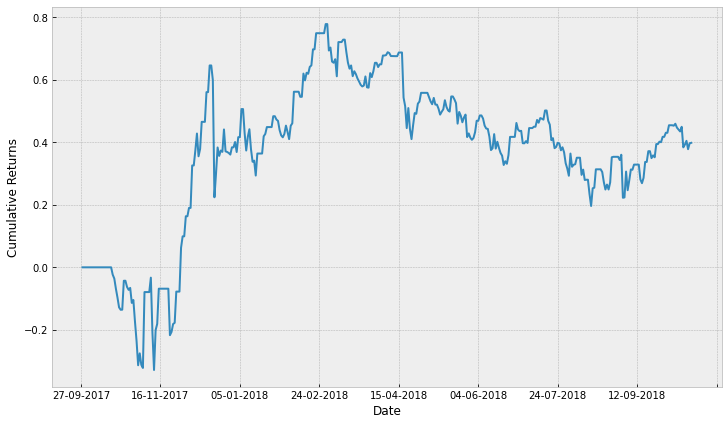

In [8]:
# Daily returns of BTC
df['daily_returns_BTC'] = df.BTC.pct_change()

# Daily returns of XMR
df.XMR = df.XMR * hedge_ratio
df['daily_returns_XMR'] = df.XMR.pct_change()

# Daily Returns
df['daily_returns'] = df.daily_returns_BTC - df.daily_returns_XMR

# Strategy Returns
df['strategy_returns'] = df.position.shift(1) * df.daily_returns

# Plot the strategy returns
df.strategy_returns.cumsum().plot(figsize=(12, 7))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

In the upcoming units, we will practice these codes in the interactive coding exercises.<br><br>